In [142]:
import numpy as np
import matplotlib.pyplot as plt

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
ZMIN, ZMAX = 0.1, 2. # for plots

In [143]:
data = np.load(FILENAME(Z_MODELING[0]), allow_pickle=True)

all_realizs = data['means_and_densities']
print(len(all_realizs))

sfr_behroozi_density = []
mass_HI_density = []
mean_CII_intensity = []

for realiz in all_realizs:
    sfr_behroozi_density.append(realiz['props']['sfr_behroozi']['density'])
    mass_HI_density.append(realiz['props']['MHI']['density'])
    mean_CII_intensity.append(realiz['lines']['LCII']['meanInu_Jy/sr'])
    
# print means and std

print("SFR Density (Behroozi et al 2013)")
print("Mean:", f"{np.mean(sfr_behroozi_density):.2e}")
print("Std:", f"{np.std(sfr_behroozi_density):.2e}")
print()

print("HI mass (Padmanabhan et al 2017)")
print("Mean:", f"{np.mean(mass_HI_density):.2e}")
print("Std:", f"{np.std(mass_HI_density):.2e}")
print()

print("CII intensity (Delooze et al 2014)")
print("Mean:", f"{np.mean(mean_CII_intensity):.2e}")
print("Std:", f"{np.std(mean_CII_intensity):.2e}")
print()

10
SFR Density (Behroozi et al 2013)
Mean: 4.74e-02
Std: 2.61e-04

HI mass (Padmanabhan et al 2017)
Mean: 5.29e+07
Std: 6.46e+06

CII intensity (Delooze et al 2014)
Mean: 4.04e+03
Std: 1.87e+03



In [144]:
sfr_behroozi_density, mass_HI_density, mean_CII_intensity = [], [], []

for z in Z_MODELING:
    data = np.load(FILENAME(z), allow_pickle=True)
    all_realizs = data['means_and_densities']
    print(len(all_realizs))
    
    sfr, mass_HI, mean_CII = [], [], []
    
    for realiz in all_realizs:
        sfr.append(realiz['props']['sfr_behroozi']['density'])
        mass_HI.append(realiz['props']['MHI']['density'])
        mean_CII.append(realiz['lines']['LCII']['meanInu_Jy/sr'])
    sfr_behroozi_density.append(np.array(sfr))
    mass_HI_density.append(np.array(mass_HI))
    mean_CII_intensity.append(np.array(mean_CII))

sfr_behroozi_density, mass_HI_density, mean_CII_intensity = np.array(sfr_behroozi_density).T, np.array(mass_HI_density).T, np.array(mean_CII_intensity).T

10
10
10
10


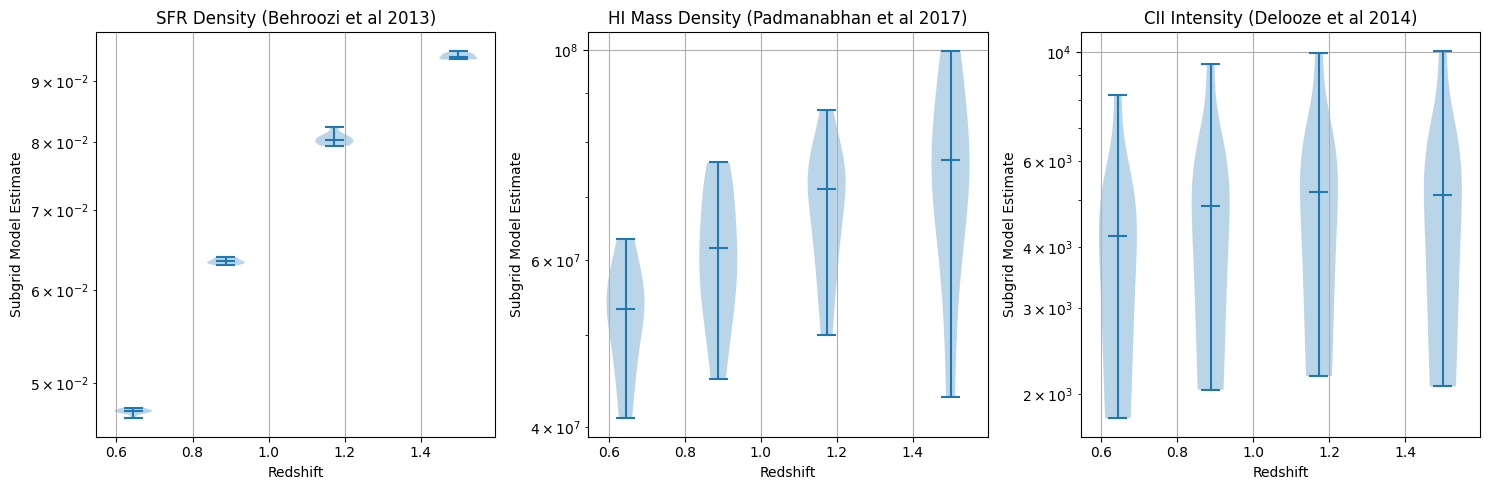

In [80]:
# make a violin plot of the densities
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
kwargs = {'showmedians': True, 'widths': 0.1, 'positions': Z_MODELING}

titles = ['SFR Density (Behroozi et al 2013)', 
        'HI Mass Density (Padmanabhan et al 2017)', 
        'CII Intensity (Delooze et al 2014)']

for ax, titl, vals in zip(axs, titles, [sfr_behroozi_density, mass_HI_density, mean_CII_intensity]):
    ax.violinplot(vals, **kwargs)
    ax.set_title(titl)
    ax.set_ylabel('Subgrid Model Estimate')
    ax.set_xlabel('Redshift')
    ax.grid(True)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [81]:
def rho_x(z, A, B, C, D):
    return (A * (1 + z) ** B) / (1 + ((1 + z) / C) ** D)

def rho_HI(z, A, B, C):
    return A * np.tanh(1 + z - B) + C

# Redshift range
z = np.linspace(ZMIN, ZMAX, 100)

# Parameters from the table
# params_rho_H2 = (1.00e7, 3.0, 2.3, 5.1)
# uncert_rho_H2 = (0.14e7, 0.6, 0.3, 0.5)

# params_rho_stars = (1.3e10, -4.1, 2.5, -3.8)
# uncert_rho_stars = (1.0e10, 0.4, 0.4, 0.3)

params_psi_stars = (0.0158, 2.88, 2.75, 5.88)
uncert_psi_stars = (0.0010, 0.16, 0.11, 0.15)

params_psi_starsMD = (0.0158, 2.7, 2.9, 5.6)

params_rho_HI = (4.5e7, 2.8, 1.01e8)
uncert_rho_HI = (0.5e7, 0.4, 0.07e8)

# Compute best-fit values
psi_stars_best = rho_x(z, *params_psi_stars)
rho_HI_best = rho_HI(z, *params_rho_HI)
psi_starsMD_best = rho_x(z, *params_psi_starsMD)

In [82]:
# sample psi stars and rho HI based on sigma in fits

np.random.seed(1511)  # for reproducibility

NSAMPLES = 1000
psi_stars_paras = np.random.normal(params_psi_stars, uncert_psi_stars, (NSAMPLES, len(params_psi_stars)))
rho_HI_paras = np.random.normal(params_rho_HI, uncert_rho_HI, (NSAMPLES, len(params_rho_HI)))

psi_stars = np.array([rho_x(z, *paras) for paras in psi_stars_paras])
rho_HIs = np.array([rho_HI(z, *paras) for paras in rho_HI_paras])

# get 1 sigma confidence intervals
percentiles = [16, 84]
psi_stars_lower = np.percentile(psi_stars, percentiles[0], axis=0)
psi_stars_upper = np.percentile(psi_stars, percentiles[1], axis=0)
rho_HI_lower = np.percentile(rho_HIs, percentiles[0], axis=0)
rho_HI_upper = np.percentile(rho_HIs, percentiles[1], axis=0)

In [83]:
import pickle

Agrawalzbins = [(.33, .86), (1.0, 1.6), (1.6, 2.3), (2.3, 2.9)]
InuCIIAgrawalbest = np.array([11.8, 11.0, 9.6, 9.2]) * 1e3
InuCIIAgrawalsig = np.array([10.2, 8.7, 9.8, 6.6]) * 1e3

with open('./data/ciihistorymodels.pkl', 'rb') as f:
    ciihistorymodels = pickle.load(f)
print(ciihistorymodels.keys())

from simim.galprops.log10normal import log10normal
behroozisfrfit = np.loadtxt('./data/behroozi13sfr.csv', delimiter=',')
behsfr_z, behsfr_psi = behroozisfrfit[:, 0], behroozisfrfit[:, 1]

# add .15 dex scatter
behsfr_psis = np.array([log10normal(behsfr_psi, 0.15, preserve_linear_mean=True) for _ in range(NSAMPLES)])
behsfr_psi_lower = np.percentile(behsfr_psis, percentiles[0], axis=0)
behsfr_psi_upper = np.percentile(behsfr_psis, percentiles[1], axis=0)

dict_keys(['Keenan et al 2024', 'Yang et al 2022', 'Padmanabhan et al 2019'])


In [124]:
# import data points
walterdata = np.loadtxt('./data/walter20rhohi.csv', delimiter=',', skiprows=1)
print(walterdata.shape)

MDdata = np.loadtxt('./data/MDsfr.csv', delimiter=',', skiprows=1)
print(MDdata.shape)

(39, 5)
(51, 5)


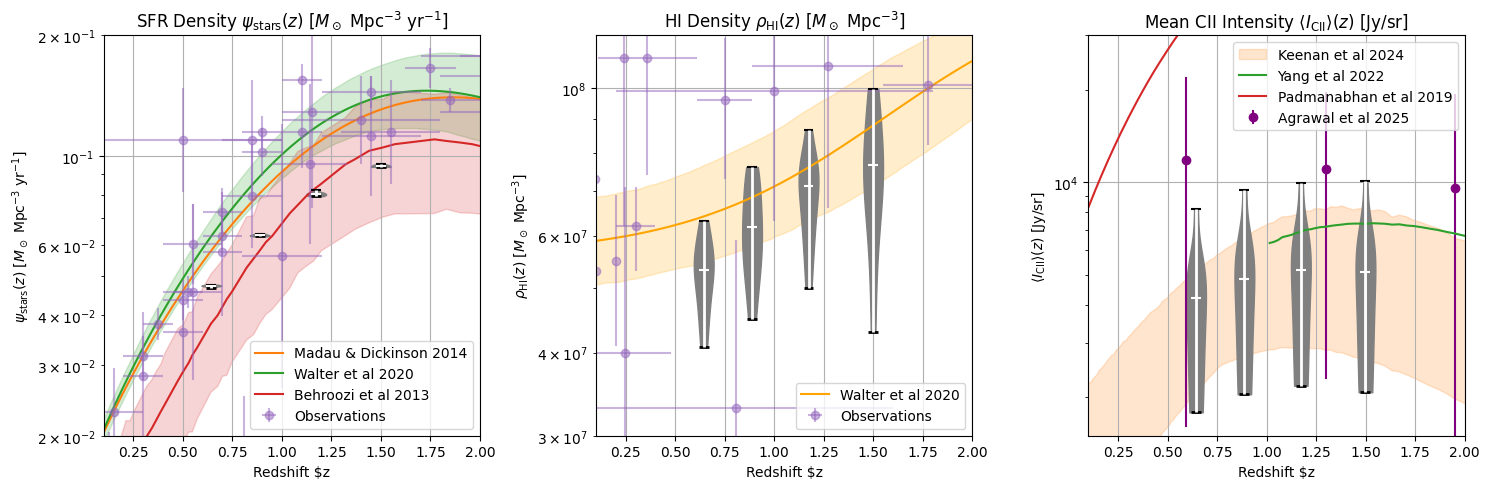

In [141]:
# make a violin plot of the densities
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
kwargs = {'showmedians': True, 'widths': 0.1, 'positions': Z_MODELING}

# titles = ['SFR Density (Behroozi et al 2013)', 
#         'HI Mass Density (Padmanabhan et al 2017)', 
#         'CII Intensity (Delooze et al 2014)']

titles = [r'SFR Density $\psi_\text{stars}(z)$ [$M_\odot$ Mpc$^{-3}$ yr$^{-1}$]', 
        r'HI Density $\rho_\text{HI}(z)$ [$M_\odot$ Mpc$^{-3}$]',
        r'Mean CII Intensity $\langle I_\text{CII} \rangle(z)$ [Jy/sr]']

for i, ax, titl, viovals in zip(range(len(axs)), axs, titles, [sfr_behroozi_density, mass_HI_density, mean_CII_intensity]):
    ax.set_title(titl)
    ax.set_ylabel(titl[titl.index('$'):])
    ax.set_xlabel(r'Redshift $z')
    ax.grid(True)
    ax.set_yscale('log')
    ax.set_xlim(ZMIN, ZMAX)
    if i == 0:
        ax.plot(z, psi_starsMD_best, label='Madau & Dickinson 2014', color='C1')
        ax.plot(z, psi_stars_best, label='Walter et al 2020', color='C2')
        ax.fill_between(z, psi_stars_lower, psi_stars_upper, color='C2', alpha=0.2)
        ax.plot(behsfr_z, behsfr_psi, label='Behroozi et al 2013', color='C3')
        ax.fill_between(behsfr_z, behsfr_psi_lower, behsfr_psi_upper, color='C3', alpha=0.2)
        ax.set_ylim(2e-2, 2e-1)
        
        label = 'Observations'
        for zmin,zmax,bestlogpsi,logpsierrlower,logpsierrupper in MDdata:
            yerr = [[10**bestlogpsi - 10**(bestlogpsi - logpsierrlower)], 
                    [10**(bestlogpsi + logpsierrupper) - 10**bestlogpsi]]
            ax.errorbar((zmin+zmax)/2, 10**bestlogpsi, yerr=yerr, 
                        xerr=[[ (zmax - zmin)/2 ], [ (zmax - zmin)/2 ]], 
                        fmt='o', color='C4', alpha=0.5, label=label)
            label = None  # only label the first point
        
    elif i == 1:
        ax.plot(z, rho_HI_best, label='Walter et al 2020', color='orange')
        ax.fill_between(z, rho_HI_lower, rho_HI_upper, color='orange', alpha=0.2)
        ax.set_ylim(3e7, 1.2e8)
        
        label = 'Observations'
        for zmin,zmax,bestrho,rhoerrlower,rhoerrupper in walterdata:
            ax.errorbar((zmin+zmax)/2, 1e8*bestrho, 
                        yerr=[[1e8*rhoerrlower], [1e8*rhoerrupper]], 
                        xerr=[[ (zmax - zmin)/2 ], [ (zmax - zmin)/2 ]], 
                        fmt='o', color='C4', alpha=0.5, label=label)
            label = None  # only label the first point
        
    elif i == 2:
        ax.errorbar([(zb[0] + zb[1]) / 2 for zb in Agrawalzbins], 
                    InuCIIAgrawalbest, 
                    yerr=InuCIIAgrawalsig, 
                    fmt='o', 
                    label='Agrawal et al 2025', 
                    color='purple')
        ax.set_ylim(1.5e3, 3e4)
        for i, (label, (zs, vals)) in enumerate(ciihistorymodels.items()):
            if "Keenan" in label:
                ax.fill_between(zs, vals[0], vals[1], 
                                color=f'C{i+1}', alpha=0.2, label=label)
            else:
                ax.plot(zs, vals, 
                        color=f'C{i+1}', alpha=1, label=label)
        
    parts = ax.violinplot(viovals, **kwargs)
    for pc in parts['bodies']:
        pc.set_facecolor("grey")
        pc.set_edgecolor('grey')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('white')
    parts['cbars'].set_edgecolor('white')
    parts['cmins'].set_edgecolor('black')
    parts['cmaxes'].set_edgecolor('black')
    parts['cbars'].set_linewidth(2)
    parts['cmins'].set_linewidth(2)
    ax.legend()

plt.tight_layout()
plt.savefig('../figs/validation_violins.pdf', dpi=300)
plt.show()
plt.close()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as cst, units as u

Z_MODELING = [.32, .44]
ZIDX = 0
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'

In [13]:
data = np.load(FILENAME(Z_MODELING[ZIDX]), allow_pickle=True)

ks = data['k']
pshi = data['ps_hi'] * u.Jy**2 * u.Mpc**3
lambda_hi = .21 * u.m
z = data['z_modeling']
lobs = lambda_hi * (1 + z)

pshi = ((pshi * (lobs ** 2 / 2 / cst.k_B) ** 2) / (u.mK**2 * u.Mpc**3)).decompose().value

In [14]:
paul23data = np.loadtxt(f'./data/paul23_z_{z:.2f}.csv', delimiter=',', skiprows=1)
p23ks, p23pshi, p23err = paul23data[:,0], paul23data[:,1], paul23data[:,2]

In [15]:
from scipy.interpolate import interp1d

pshimedian = np.median(pshi, axis=0)
pshilow = np.percentile(pshi, 16, axis=0)
pshiup = np.percentile(pshi, 84, axis=0)

masknans = np.isfinite(pshimedian) & np.isfinite(pshilow) & np.isfinite(pshiup)
logfit = interp1d(ks[masknans], np.log10(pshimedian[masknans]), kind='cubic', fill_value='extrapolate')

# curve fit for amplitude scaling
from scipy.optimize import curve_fit
def func(ks, A):
    return A * 10 ** logfit(ks)

popt, pcov = curve_fit(func, p23ks, p23pshi, sigma=p23err, absolute_sigma=True, p0=[5.0])
perr = np.sqrt(np.diag(pcov))
print("Best-fit amplitude scaling A = ", popt[0], "+/-", perr[0])

Best-fit amplitude scaling A =  2.04914564422336 +/- 0.28695533084011404


In [16]:
np.savetxt(f'./forjames_paulzs_{z:.2f}.csv', np.array([ks, pshimedian, pshilow, pshiup]).T, delimiter=',', header='k, P(k)_50, P(k)_16, P(k)_84', comments='')

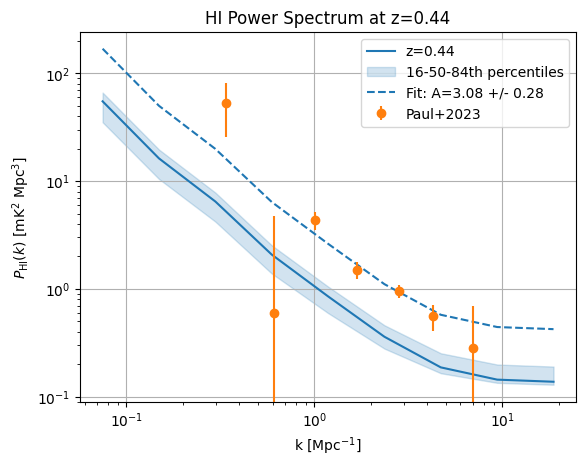

In [94]:
plt.figure()
plt.loglog(ks, pshimedian, label=f'z={z:.2f}')
plt.fill_between(ks, pshilow, pshiup, color='C0', alpha=0.2, label='16-50-84th percentiles')
plt.loglog(ks[masknans], func(ks[masknans], *popt), '--', color='C0', label=f'Fit: A={popt[0]:.2f} +/- {perr[0]:.2f}')
plt.errorbar(p23ks, p23pshi, yerr=p23err, fmt='o', color='C1', label='Paul+2023')
plt.title(f'HI Power Spectrum at z={z:.2f}')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_\text{HI}(k)$ [mK$^2$ Mpc$^3$]')
plt.legend()
plt.grid()
plt.show()
plt.close()